# Двухэтапная модель

In [170]:
import datetime
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sparse

from catboost import CatBoostClassifier
import implicit

import warnings
warnings.simplefilter('ignore')

# Датасет КИОН

- просмотры фильмов и сериалов в приложении KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

## Загрузим данные

In [97]:
interactions = pd.read_csv("interactions.csv")
items = pd.read_csv("items.csv")
users = pd.read_csv("users.csv")

# EDA

## `interactions`: взаимодействия пользователь - айтем
- `last_watch_dt` дата просмотра
- `total_dur` длительность просмотра
- `watched_pct` доля просмотра в %

In [98]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [99]:
# обработка даты
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique()}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique()}")

Уникальных юзеров в interactions: 962179
Уникальных айтемов в interactions: 15706


In [100]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")

min дата в interactions: 2021-03-13
max дата в interactions: 2021-08-22


## `users`: данные о пользователях

- `age` бин по возрасту
- `income` бин по доходу
- `sex` пол
- `kids_flg` флаг наличия детей

Все признаки - результат предсказания соцдем моделей

In [101]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [102]:
f"Уникальных юзеров в users: {users.shape[0]}"

'Уникальных юзеров в users: 840197'

## `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова
- `description` - описание

In [103]:
items.head(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [104]:
f"Уникальных айтемов в items {items.shape[0]}"

'Уникальных айтемов в items 15963'

# Train-test split

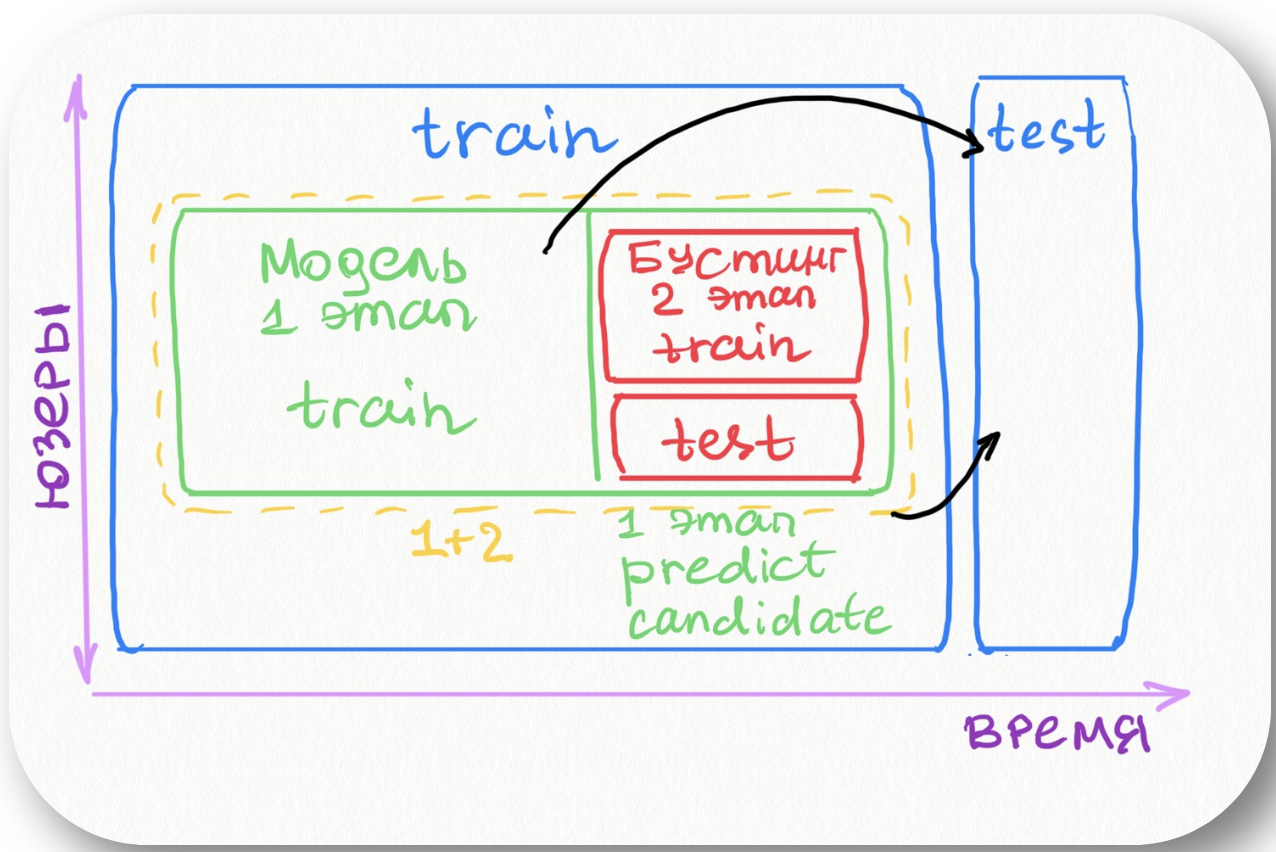

## Глобальный train - test

На `test` будем проверять результат обоих моделей:
-  отдельно модели 1го уровня
- отдельно двухуровненой модели

На test оставим 7 дней

In [105]:
# фильтрация для исключения случайных просмотров
interactions = interactions[interactions['total_dur'] >= 300]

In [106]:
user_interactions_count = interactions.groupby('user_id')[['item_id']].count().reset_index()

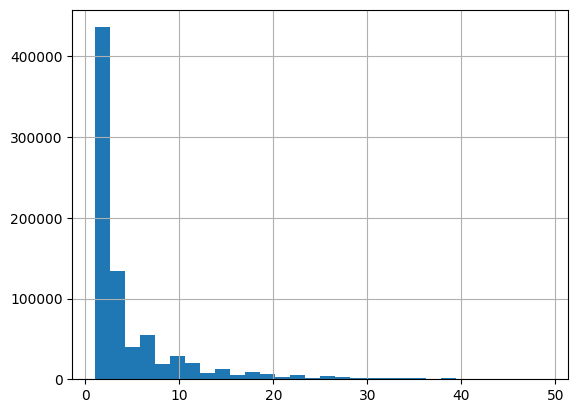

In [107]:
user_interactions_count[user_interactions_count['item_id'] < 50]['item_id'].hist(bins=30)
plt.show()

In [108]:
sum(user_interactions_count['item_id'] < 10) / user_interactions_count.shape[0]

0.8652543241717588

In [109]:
filtered_users = user_interactions_count[user_interactions_count['item_id'] >= 10][['user_id']]
interactions = filtered_users.merge(interactions, how='left')

In [110]:
item_interactions_count = interactions.groupby('item_id')[['user_id']].count().reset_index()

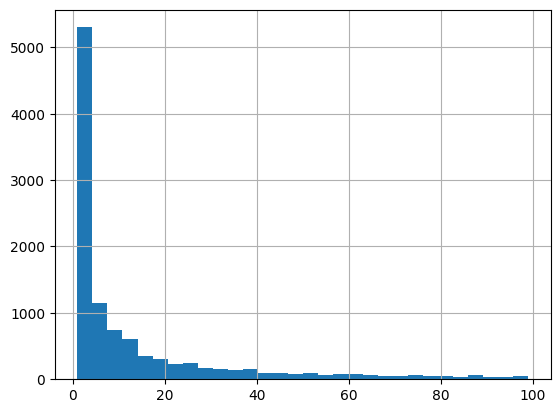

In [111]:
item_interactions_count[item_interactions_count['user_id'] < 100]['user_id'].hist(bins=30)
plt.show()

In [112]:
sum(item_interactions_count['user_id'] < 10) / item_interactions_count.shape[0]

0.5165371809100999

In [113]:
filtered_items = item_interactions_count[item_interactions_count['user_id'] >= 10][['item_id']]
interactions = filtered_items.merge(interactions, how='left')

In [114]:
interactions.shape

(2300516, 5)

In [115]:
test_threshold = max_date - pd.Timedelta(days=7)
val_threshold = test_threshold - pd.Timedelta(days=30) # один месяц для обучения модели второго уровня

test = interactions[(interactions['last_watch_dt'] >= test_threshold)]
train_val = interactions[(interactions['last_watch_dt'] < test_threshold)]

val = train_val[(train_val['last_watch_dt'] >= val_threshold)]
train = train_val[(train_val['last_watch_dt'] < val_threshold)]

print(f"train: {train.shape}")
print(f"val: {val.shape}")
print(f"test: {test.shape}")

train: (1462735, 5)
val: (665188, 5)
test: (172593, 5)


# 1 этап: модель первого уровня

- обучаем bpr и als модели из библиотеки implicit на train

- делаем предикт c кандидатами на val



Будем предсказывать кандидатов только на теплых пользователях - у которых есть просмотры в обучающей выборке

In [116]:
val = val[val['user_id'].isin(train['user_id'].unique())]

In [117]:
val.head()

,item_id,user_id,last_watch_dt,total_dur,watched_pct
1,0,184560,2021-07-18,13278,50.0
5,0,427911,2021-08-11,5363,38.0
7,0,573405,2021-08-01,10164,9.0
15,0,968581,2021-08-04,7310,6.0
18,1,163497,2021-07-19,4791,78.0


<div>Из-за того что мы к делали merge к filtered_items,  у нас появились nan в interactions<br>interactions = filtered_items.merge(interactions, how='left')<br>Удалим строки с nan</div>

In [118]:
train = train.dropna()
val = val.dropna()

In [119]:
users_id = list(np.sort(train.user_id.unique()))
items_train = list(train.item_id.unique())
ratings_train = list(train.watched_pct)

rows_train = train.user_id.astype('category').cat.codes
cols_train = train.item_id.astype('category').cat.codes

train_sparse = sparse.csr_matrix((ratings_train, (rows_train, cols_train)), shape=(len(users_id), len(items_train)))

In [120]:
matrix_size = train_sparse.shape[0] * train_sparse.shape[1] # Number of possible interactions in the matrix
num_interactions = len(train_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100 * (1 - (num_interactions / matrix_size))
sparsity

99.7557182691207

In [121]:
train_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1462509 stored elements and shape (93095, 6308)>

Фильтр просмотренных фильмов осуществляется за счет умножения их скоров на 0. Этот способ выбран из-за скорости вычислений. Для полученных нами скоров такой способ подходит, потому что у каждого пользователя достаточно фильмов с положительными скорами. Но вообще говоря, при использовании ранжирующих лоссов большинство скоров могут быть отрицательными, и тогда данный способ не подойдет.

In [122]:
def predict(user_vecs, item_vecs, interaction_matrix, k=10):
    id2user = dict(zip(rows_train, train.user_id))
    id2item = dict(zip(cols_train, train.item_id))

    scores = user_vecs.dot(item_vecs.T)
    scores = np.multiply(
                scores,
                np.invert(interaction_matrix.todense().astype(bool))
                ) # фильтр просмотренных фильмов

    ind_part = np.argpartition(scores, -k)[:, -k:].copy()
    scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
    ind_sorted = np.argsort(scores_not_sorted, axis=1)
    indices = np.take_along_axis(ind_part, ind_sorted, axis=1)
    indices = np.flip(indices, 1)
    preds = pd.DataFrame({
        'user_id': range(user_vecs.shape[0]),
        'preds': indices.tolist(),
        })
    preds['user_id'] = preds['user_id'].map(id2user)
    preds['preds'] = preds['preds'].map(lambda inds: [id2item[i] for i in inds])
    return preds

In [123]:
algo_als = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.01, iterations=50, use_gpu=False)
algo_als.fit((train_sparse).astype('double'))

user_vecs_als = algo_als.user_factors
item_vecs_als = algo_als.item_factors

algo_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=50, regularization=0.01, iterations=20, use_gpu=False)
algo_bpr.fit((train_sparse).astype('double'))

user_vecs_bpr = algo_bpr.user_factors
item_vecs_bpr = algo_bpr.item_factors

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [124]:
val_user_history = val.groupby('user_id')[['item_id']].agg(lambda x: list(x))

pred_als = predict(user_vecs_als, item_vecs_als, train_sparse, k=100)
pred_als = val_user_history.merge(pred_als, how='left', on='user_id')

pred_bpr = predict(user_vecs_bpr, item_vecs_bpr, train_sparse, k=100)
pred_bpr = val_user_history.merge(pred_bpr, how='left', on='user_id')

In [126]:
def recall(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    recall_values = []
    for _, row in df.iterrows():
      num_relevant = len(set(row[true_col]) & set(row[pred_col][:k]))
      num_true = len(row[true_col])
      recall_values.append(num_relevant / num_true)
    return np.mean(recall_values)

def precision(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    precision_values = []
    for _, row in df.iterrows():
      num_relevant = len(set(row[true_col]) & set(row[pred_col][:k]))
      num_true = min(k, len(row[true_col]))
      precision_values.append(num_relevant / num_true)
    return np.mean(precision_values)

def mrr(df: pd.DataFrame, pred_col='preds', true_col='item_id', k=30) -> float:
    mrr_values = []
    for _, row in df.iterrows():
      intersection = set(row[true_col]) & set(row[pred_col][:k])
      user_mrr = 0
      if len(intersection) > 0:
          for item in intersection:
              user_mrr = max(user_mrr, 1 / (row[pred_col].index(item) + 1))
      mrr_values.append(user_mrr)
    return np.mean(mrr_values)

In [127]:
print(f'Recall score als: {recall(pred_als, k=20)}')
print(f'Recall score bpr: {recall(pred_bpr, k=20)}')

Recall score als: 0.1519128002872403
Recall score bpr: 0.14547491646675717


In [128]:
print(f'Precision score als: {precision(pred_als, k=20)}')
print(f'Precision score bpr: {precision(pred_bpr, k=20)}')

Precision score als: 0.153761680111176
Precision score bpr: 0.14688784482623868


In [129]:
print(f'MRR score als: {mrr(pred_als,k=20)}')
print(f'MRR score bpr: {mrr(pred_bpr,k=20)}')

MRR score als: 0.18102559551076425
MRR score bpr: 0.21239677978567365


Мы берем по 100 кандидатов от каждой модели. Если при объединение возникает nan, то значить одна из моделей посчитала фильм малозначимым, и мы присвоим ему ранк 200, чтобы это показать.

In [130]:
# генерируем предказания
candidates_als = pred_als[['user_id', 'preds']]
candidates_bpr = pred_bpr[['user_id', 'preds']]

candidates_als = candidates_als.explode(['preds'])
candidates_bpr = candidates_bpr.explode(['preds'])

candidates_als['rank_als'] = candidates_als.groupby('user_id').cumcount() + 1
candidates_bpr['rank_bpr'] = candidates_bpr.groupby('user_id').cumcount() + 1

candidates = candidates_als.merge(candidates_bpr, how='outer', on=['user_id','preds']).rename(columns={'preds':'item_id'})

candidates = candidates.fillna(200)

In [131]:
candidates

,user_id,item_id,rank_als,rank_bpr
0,21,24,200.0,39.0
1,21,47,200.0,92.0
2,21,142,34.0,200.0
3,21,274,82.0,200.0
4,21,288,200.0,55.0
...,...,...,...,...
11890349,1097521,16029,91.0,200.0
11890350,1097521,16201,200.0,22.0
11890351,1097521,16270,76.0,200.0
11890352,1097521,16346,54.0,200.0


# 2 этап: обучаем бустинг (`CatBoost`)

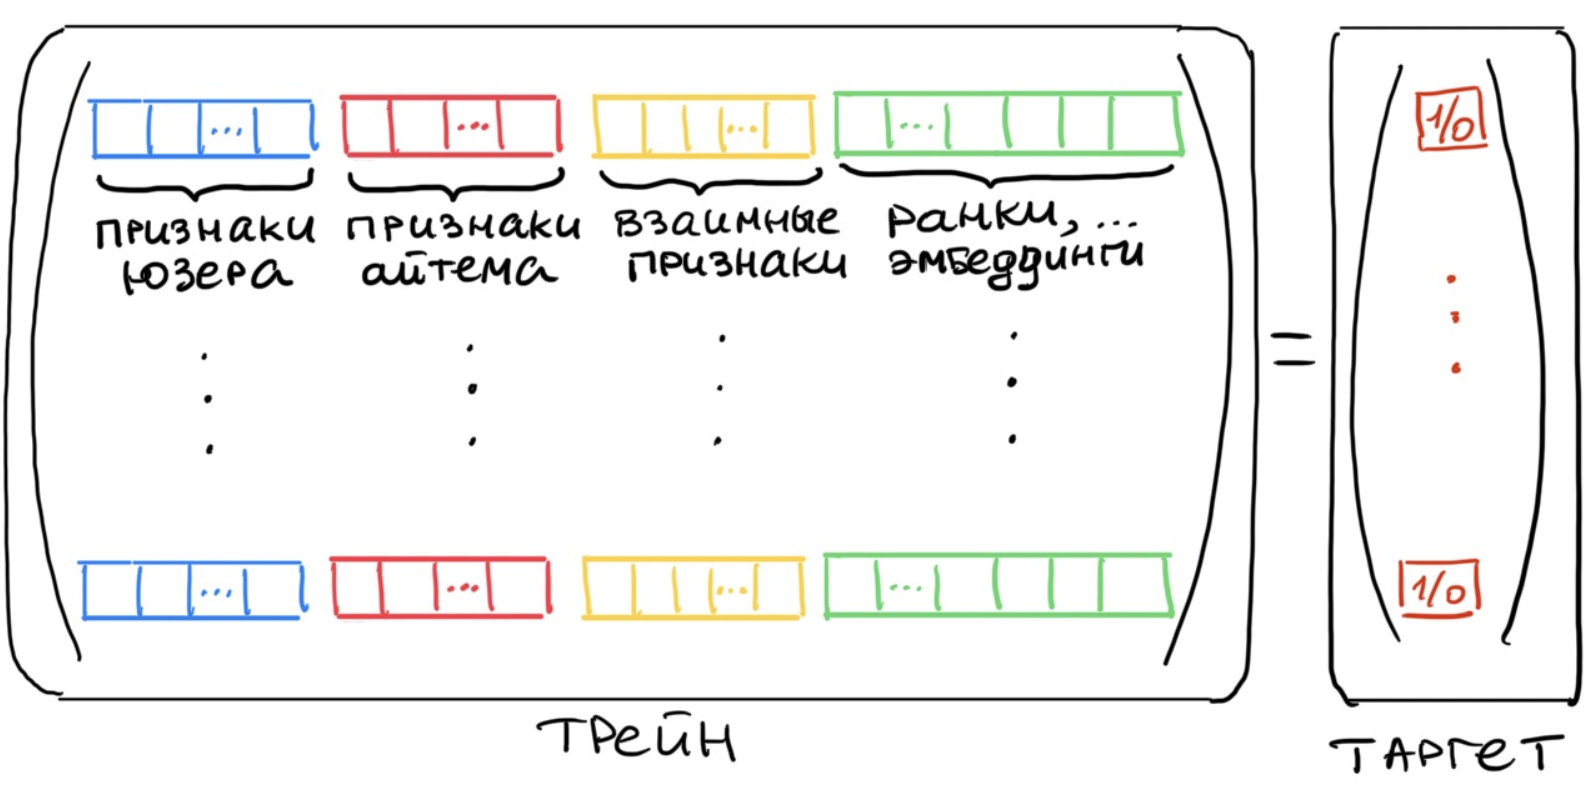

- Ставим задачу как бинарную классификацию
- Выбираем `CatBoostClassifier`, так как много категориальных признаков

##  Собираем train + target

### `target = 1` Позитивные взаимодействия = все что пользователь посмотрел из кандидатов bpr + als

In [132]:
pos = candidates.merge(val,
                       on=['user_id', 'item_id'],
                       how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(158890, 8)


,user_id,item_id,rank_als,rank_bpr,last_watch_dt,total_dur,watched_pct,target
0,53,142,5.0,5.0,2021-07-30,9141,100.0,1
1,53,3734,1.0,3.0,2021-07-30,11529,100.0,1
2,53,4151,3.0,1.0,2021-07-29,4302,13.0,1
3,60,15297,15.0,2.0,2021-07-24,14896,88.0,1
4,98,4740,67.0,200.0,2021-07-22,6612,92.0,1


### `target = 0` Негативные взаимодействия = все что пользователь НЕ посмотрел из кандидатов bpr + als

- добавим сэмплирование, чтобы соблюсти баланс классов

In [133]:
neg = candidates.set_index(['user_id', 'item_id'])\
        .join(val.set_index(['user_id', 'item_id']))

neg = neg[neg['watched_pct'].isnull()].reset_index()

In [135]:
pos.shape[0] / neg.shape[0]

0.013543919156211023

In [136]:
# пусть негативных семплов будет в 2.5 раза больше, чем позитивных
neg = neg.sample(frac=0.03)
neg['target'] = 0

neg.shape

(351944, 8)

In [137]:
neg

,user_id,item_id,rank_als,rank_bpr,last_watch_dt,total_dur,watched_pct,target
11373495,1064709,12574,200.0,80.0,NaN,NaN,NaN,0
7901128,736520,4131,200.0,26.0,NaN,NaN,NaN,0
3286760,307942,13865,28.0,3.0,NaN,NaN,NaN,0
5340566,498597,15352,69.0,200.0,NaN,NaN,NaN,0
7102663,663605,1048,200.0,48.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
11219938,1050262,16509,200.0,35.0,NaN,NaN,NaN,0
9540700,892171,3935,87.0,200.0,NaN,NaN,NaN,0
4394963,410384,7417,80.0,15.0,NaN,NaN,NaN,0
746633,71054,14598,200.0,29.0,NaN,NaN,NaN,0


## Формируем трейн и тест: ctb_train, ctb_test

### Важно! Делим по пользователям, а не по дате.

`Мотивация`:

- Для негативных взаимодействий нет даты
- Проверяем устойчивость бустинга относительно новых (холодных) пользователей

In [138]:
ctb_train_users, ctb_test_users = train_test_split(val['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

In [139]:
# выделяем 10% под механизм early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [140]:
select_col = ['user_id', 'item_id', 'rank_als','rank_bpr', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)

### Проверяем баланс классов

In [141]:
ctb_train['target'].value_counts(normalize=True)

target
0    0.689387
1    0.310613
Name: proportion, dtype: float64

In [142]:
ctb_test['target'].value_counts(normalize=True)

target
0    0.689275
1    0.310725
Name: proportion, dtype: float64

## Формируем фичи

- бейзлайн с минимальной обработкой признаков - оставляем ее для Catboost
- выбираем простые категориальные признаки, которые не нужно предобрабатывать
- также добавим кол-во признаков равное кол-во месяцев, которые отразят популярность фильмов в каждом из них (кол-во просмотров)
- как признак также используем `rank` от моделей 1 этапа
- заполняем пропуски в данных

In [143]:
interactions['year_month'] = pd.to_datetime(interactions['last_watch_dt']).dt.to_period('M')

In [144]:
populars_months = interactions.groupby(['year_month','item_id']).count()[['user_id']].reset_index()

In [145]:
popular_features = []
for month in populars_months['year_month'].unique():
    items = items.merge(populars_months[populars_months['year_month']==month][['item_id','user_id']],how='left',on='item_id')
    items['user_id'] = items['user_id'].fillna(0)
    items.rename(columns={'user_id':f'popular_{month}'},inplace=True)
    popular_features.append(f'popular_{month}')

In [146]:
user_col = ['user_id', 'age', 'income', 'sex', 'kids_flg']
item_col = ['item_id', 'content_type', 'countries', 'for_kids', 'age_rating', 'studios', 'release_year']

item_col.extend(popular_features)

In [147]:
items

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,popular_2021-03,popular_2021-04,popular_2021-05,popular_2021-06,popular_2021-07,popular_2021-08
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",0.0,0.0,0.0,0.0,0.0,0.0
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",0.0,0.0,0.0,0.0,0.0,0.0
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",0.0,0.0,0.0,0.0,0.0,0.0
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...",0.0,0.0,0.0,0.0,0.0,0.0
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...",0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15958,6443,series,Полярный круг,Arctic Circle,2018.0,"драмы, триллеры, криминал","Финляндия, Германия",NaN,16.0,NaN,Ханну Салонен,"Иина Куустонен, Максимилиан Брюкнер, Пихла Вии...","Во время погони за браконьерами по лесу, сотру...","убийство, вирус, расследование преступления, н...",0.0,0.0,0.0,1672.0,1545.0,434.0
15959,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия",16.0,31.0,54.0,49.0,1.0,92.0
15960,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия",4.0,4.0,6.0,4.0,8.0,4.0
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия",13.0,12.0,8.0,0.0,0.0,3.0


In [148]:
train_feat = (ctb_train
              .merge(users[user_col], on=['user_id'], how='left')
              .merge(items[item_col], on=['item_id'], how='left'))

eval_feat = (ctb_eval
             .merge(users[user_col], on=['user_id'], how='left')
             .merge(items[item_col], on=['item_id'], how='left'))

In [149]:
train_feat.head()

,user_id,item_id,rank_als,rank_bpr,target,age,income,sex,kids_flg,content_type,...,for_kids,age_rating,studios,release_year,popular_2021-03,popular_2021-04,popular_2021-05,popular_2021-06,popular_2021-07,popular_2021-08
0,1034257,12995,21.0,8.0,1,age_65_inf,income_20_40,М,0.0,film,...,NaN,18.0,NaN,2020.0,0.0,0.0,0.0,7147.0,1838.0,837.0
1,389434,3734,200.0,42.0,0,age_65_inf,income_20_40,Ж,0.0,film,...,NaN,16.0,NaN,2021.0,0.0,0.0,0.0,9534.0,12847.0,4163.0
2,386595,7210,10.0,200.0,0,age_25_34,income_20_40,М,0.0,film,...,NaN,16.0,NaN,2017.0,377.0,550.0,361.0,698.0,787.0,662.0
3,918975,8139,91.0,200.0,0,age_25_34,income_40_60,М,1.0,film,...,NaN,12.0,NaN,2010.0,12.0,29.0,135.0,125.0,46.0,43.0
4,71704,8801,85.0,200.0,0,age_35_44,income_20_40,Ж,0.0,film,...,NaN,16.0,NaN,2009.0,227.0,216.0,349.0,522.0,966.0,0.0


### X, y

In [150]:
drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = ['age', 'income', 'sex', 'content_type', 'countries', 'studios']

In [151]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

In [152]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((367225, 18), (367225, 1), (40975, 18), (40975, 1))

In [153]:
# fillna for catboost with the most frequent value
X_train = X_train.fillna(X_train.mode().iloc[0])

In [154]:
# fillna for catboost with the most frequent value
X_val = X_val.fillna(X_train.mode().iloc[0])

In [155]:
X_train.head()

,rank_als,rank_bpr,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios,release_year,popular_2021-03,popular_2021-04,popular_2021-05,popular_2021-06,popular_2021-07,popular_2021-08
0,21.0,8.0,age_65_inf,income_20_40,М,0.0,film,Китай,0.0,18.0,CBS All Access,2020.0,0.0,0.0,0.0,7147.0,1838.0,837.0
1,200.0,42.0,age_65_inf,income_20_40,Ж,0.0,film,Россия,0.0,16.0,CBS All Access,2021.0,0.0,0.0,0.0,9534.0,12847.0,4163.0
2,10.0,200.0,age_25_34,income_20_40,М,0.0,film,США,0.0,16.0,CBS All Access,2017.0,377.0,550.0,361.0,698.0,787.0,662.0
3,91.0,200.0,age_25_34,income_40_60,М,1.0,film,"Франция, США",0.0,12.0,CBS All Access,2010.0,12.0,29.0,135.0,125.0,46.0,43.0
4,85.0,200.0,age_35_44,income_20_40,Ж,0.0,film,США,0.0,16.0,CBS All Access,2009.0,227.0,216.0,349.0,522.0,966.0,0.0


## Обучаем `CatBoostClassifier`

- аналогично 1 этапу, предполагаем что оптимальные гиперпараметры уже выбраны
- используем только механизм early_stopping для выбора оптимального количества деревьев на небольшой валидационной выборке

In [223]:
# параметры для обучения
est_params = {
  'subsample': 0.6,
  'max_depth': 8,
  'n_estimators': 1200,
  'learning_rate': 0.01,
  'thread_count': 8,
  'random_state': 42,
  'verbose': 200,
  'min_child_samples': 10,
}

ctb_model = CatBoostClassifier(**est_params)

In [224]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100,
              cat_features=cat_col,
              plot=True
              )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6884096	test: 0.6884733	best: 0.6884733 (0)	total: 317ms	remaining: 6m 19s
200:	learn: 0.4776498	test: 0.4843578	best: 0.4843578 (200)	total: 58s	remaining: 4m 48s
400:	learn: 0.4673992	test: 0.4753307	best: 0.4753307 (400)	total: 1m 52s	remaining: 3m 44s
600:	learn: 0.4640278	test: 0.4727426	best: 0.4727426 (600)	total: 2m 46s	remaining: 2m 45s
800:	learn: 0.4620921	test: 0.4715615	best: 0.4715615 (800)	total: 3m 40s	remaining: 1m 49s
1000:	learn: 0.4607366	test: 0.4709122	best: 0.4709122 (1000)	total: 4m 33s	remaining: 54.4s
1199:	learn: 0.4596077	test: 0.4704145	best: 0.4704145 (1199)	total: 5m 28s	remaining: 0us

bestTest = 0.4704144984
bestIteration = 1199



In [324]:
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.metrics import make_scorer, precision_score

# est_params = {
#   'subsample': [0.7],
#   'max_depth': [4,7,10],
#   'n_estimators': [1500],
#   'learning_rate': np.linspace(0.001,0.1,15),
#   'thread_count': [-1],
#   'random_state': [42],
#   'verbose': [200],
# }

# search = GridSearchCV(ctb_model, param_grid=est_params, scoring=make_scorer(precision_score), cv=StratifiedKFold(n_splits=3))

# def custom_fit(estimator, X, y):
#   return estimator.fit(X, y, cat_features=cat_col, eval_set=(X_val, y_val), early_stopping_rounds=100)

# fit_params={'cat_features': cat_col,
#             'eval_set': (X_val, y_val),
#             'early_stopping_rounds': 100}

# search.fit(X_train,y_train, **fit_params)

## Посмотрим на feature importance

In [225]:
imp_catboost = pd.DataFrame(X_train.columns, columns = ['feature'])
imp_catboost['importance'] = ctb_model.feature_importances_

Text(0.5, 1.0, 'Top feature importances')

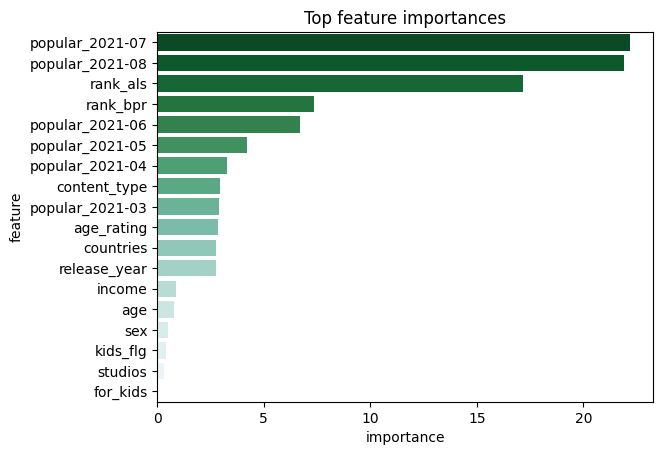

In [226]:
sns.barplot(data=imp_catboost.sort_values(by='importance', ascending=False), x='importance', y='feature', palette="BuGn_r")
plt.title('Top feature importances')

## Оценим метрики catboost модели

In [227]:
test_feat = (ctb_test
             .merge(users[user_col], on=['user_id'], how='left')
             .merge(items[item_col], on=['item_id'], how='left'))

In [228]:
# fillna for catboost with the most frequent value
test_feat = test_feat.fillna(X_train.mode().iloc[0])

In [229]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

In [230]:
X_test.head()

,rank_als,rank_bpr,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios,release_year,popular_2021-03,popular_2021-04,popular_2021-05,popular_2021-06,popular_2021-07,popular_2021-08
0,200.0,82.0,age_45_54,income_60_90,Ж,0.0,film,"Франция, США",0.0,18.0,CBS All Access,2016.0,11.0,36.0,127.0,339.0,306.0,140.0
1,39.0,52.0,age_45_54,income_20_40,Ж,0.0,series,Россия,0.0,12.0,CBS All Access,2015.0,134.0,106.0,174.0,186.0,536.0,285.0
2,9.0,11.0,age_25_34,income_40_60,Ж,1.0,film,США,0.0,6.0,CBS All Access,2013.0,37.0,154.0,251.0,601.0,676.0,675.0
3,6.0,14.0,age_35_44,income_60_90,М,0.0,film,США,0.0,16.0,CBS All Access,2016.0,224.0,384.0,329.0,310.0,1009.0,621.0
4,55.0,200.0,age_25_34,income_20_40,Ж,0.0,film,Австралия,0.0,6.0,CBS All Access,2017.0,23.0,17.0,27.0,57.0,22.0,16.0


In [231]:
y_pred = ctb_model.predict_proba(X_test)

In [232]:
f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.82'

# Метрики качества на глобальном test

- Формируем рекомендации отдельно моделью 1 этапа - bpr + als
- Отдельно двухэтапной моделью (bpr+als) + Catboost
- Сравниваем

## 1) Метрики качества bpr + als

In [233]:
# оставляем только теплых пользователей
test = test[test['user_id'].isin(val['user_id'].unique())]

In [234]:
test_user_history = test.groupby('user_id')[['item_id']].agg(lambda x: list(x))

pred_als = predict(user_vecs_als, item_vecs_als,train_sparse ,k=100)
pred_bpr = predict(user_vecs_bpr, item_vecs_bpr,train_sparse ,k=100)

pred_als = test_user_history.merge(pred_als, how='left', on='user_id')
pred_bpr = test_user_history.merge(pred_bpr, how='left', on='user_id')

In [235]:
print(f'Recall test score als: {recall(pred_als, k=20)}')
print(f'Recall test score bpr: {recall(pred_bpr, k=20)}')

Recall test score als: 0.10045628792307054
Recall test score bpr: 0.09368217967625889


In [236]:
print(f'Precision test score als: {precision(pred_als, k=20)}')
print(f'Precision test score bpr: {precision(pred_bpr, k=20)}')

Precision test score als: 0.10051681706466882
Precision test score bpr: 0.09372880247815424


In [237]:
print(f'MRR test score als: {mrr(pred_als, k=20)}')
print(f'MRR test score bpr: {mrr(pred_bpr, k=20)}')

MRR test score als: 0.061911014310367954
MRR test score bpr: 0.0753778769961257


In [238]:
# генерируем предказания
candidates_als = pred_als[['user_id', 'preds']]
candidates_bpr = pred_bpr[['user_id', 'preds']]

candidates_als = candidates_als.explode(['preds'])
candidates_bpr = candidates_bpr.explode(['preds'])

candidates_als['rank_als'] = candidates_als.groupby('user_id').cumcount() + 1
candidates_bpr['rank_bpr'] = candidates_bpr.groupby('user_id').cumcount() + 1

candidates = candidates_als.merge(candidates_bpr, how='outer', on=['user_id','preds']).rename(columns={'preds':'item_id'})

candidates = candidates.fillna(200)

## 2) Метрики качества двухэтапной модели: (`bpr`+`als`) + `Catboost`

In [241]:
candidates_ctb = candidates.copy()

# фичи для теста
score_feat = (candidates_ctb
              .merge(users[user_col], on=['user_id'], how='left')
              .merge(items[item_col], on=['item_id'], how='left'))

# fillna for catboost with the most frequent value
score_feat = score_feat.fillna(X_train.mode().iloc[0])

In [242]:
score_feat.head()

,user_id,item_id,rank_als,rank_bpr,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios,release_year,popular_2021-03,popular_2021-04,popular_2021-05,popular_2021-06,popular_2021-07,popular_2021-08
0,21,24,200.0,39.0,age_45_54,income_20_40,Ж,0.0,series,Германия,0.0,16.0,CBS All Access,2020.0,418.0,810.0,624.0,213.0,226.0,194.0
1,21,47,200.0,92.0,age_45_54,income_20_40,Ж,0.0,film,США,0.0,18.0,CBS All Access,2017.0,17.0,61.0,41.0,511.0,312.0,195.0
2,21,142,34.0,200.0,age_45_54,income_20_40,Ж,0.0,film,Россия,0.0,16.0,CBS All Access,2020.0,0.0,2500.0,5523.0,5420.0,2638.0,2500.0
3,21,274,82.0,200.0,age_45_54,income_20_40,Ж,0.0,film,США,0.0,18.0,CBS All Access,2017.0,48.0,410.0,96.0,106.0,267.0,253.0
4,21,288,200.0,55.0,age_45_54,income_20_40,Ж,0.0,film,США,0.0,16.0,CBS All Access,2008.0,0.0,67.0,949.0,523.0,576.0,247.0


In [243]:
# catboost predict_proba
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

candidates_ctb['ctb_pred'] = ctb_prediction[:, 1]
candidates_ctb.head(3)

,user_id,item_id,rank_als,rank_bpr,ctb_pred
0,21,24,200.0,39.0,0.106987
1,21,47,200.0,92.0,0.142791
2,21,142,34.0,200.0,0.394364


### Проставляем итоговый ранк двухэтапной модели

In [244]:
# сортируем по скору внутри одного пользователя и проставляем новый ранг
pred_ctb = candidates_ctb.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
pred_ctb['rank_ctb'] = pred_ctb.groupby('user_id').cumcount() + 1

In [246]:
pred_ctb.head(10)

,user_id,item_id,rank_als,rank_bpr,ctb_pred,rank_ctb
110,21,9728,31.0,1.0,0.843123,1
172,21,15297,42.0,63.0,0.804132,2
38,21,3734,200.0,10.0,0.749544,3
43,21,4151,58.0,29.0,0.713816,4
131,21,10942,8.0,200.0,0.630100,5
84,21,7626,3.0,200.0,0.625381,6
117,21,9996,15.0,200.0,0.622880,7
36,21,3095,2.0,200.0,0.618521,8
143,21,12173,10.0,200.0,0.589452,9
79,21,7210,4.0,200.0,0.573000,10


### `1+2 этапы (bpr+als) + Сatboost`: Метрики

In [247]:
true_items = test.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index()
pred_items = pred_ctb.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index().rename(columns={'item_id': 'preds'})
true_pred_items = true_items.merge(pred_items, how='left')

In [248]:
true_pred_items

,user_id,item_id,preds
0,21,"[13787, 14488]","[9728, 15297, 3734, 4151, 10942, 7626, 9996, 3..."
1,30,"[4181, 8584, 8636]","[13865, 10440, 15297, 3734, 6162, 4151, 12356,..."
2,53,"[1445, 15629, 15810, 16426]","[12192, 9728, 4151, 3734, 4495, 9996, 2657, 48..."
3,98,"[89, 512]","[9728, 10440, 13865, 3734, 15297, 9996, 4151, ..."
4,106,"[337, 1439, 2808, 2836, 5411, 6267, 10544, 128...","[7310, 2954, 11790, 5411, 9728, 16270, 13159, ..."
...,...,...,...
29905,1097460,[2225],"[12192, 9728, 13865, 4495, 142, 8636, 6809, 10..."
29906,1097486,"[931, 1916, 8419, 14025]","[10440, 4151, 11018, 4880, 5266, 6825, 13763, ..."
29907,1097508,[9985],"[15297, 10214, 4151, 11749, 3182, 14942, 5411,..."
29908,1097513,[2478],"[13865, 11018, 7626, 14317, 2852, 1785, 10942,..."


In [249]:
print(f'Recall score test (bpr+als) + catboost: {recall(true_pred_items, k=20)}')

Recall score test (bpr+als) + catboost: 0.14320850725516274


In [250]:
print(f'Precision score test (bpr+als) + catboost: {precision(true_pred_items, k=20)}')

Precision score test (bpr+als) + catboost: 0.1432875303880502


In [251]:
print(f'MRR score test (bpr+als) + catboost: {mrr(true_pred_items, k=20)}')

MRR score test (bpr+als) + catboost: 0.1087643648795215


<h2>Отчёт</h2>
<ul>
    <li>
    Из-за того что мы делали merge к filtered_items, у нас появились nan в interactions.
    interactions = filtered_items.merge(interactions, how='left'). 
    Удалим строки с nan, что позволить уже улучшить наши метрики
    </li>
    <li>
    Был выделен один месяц для обучения модели второго уровня, четыре месяца - для модели первого уровня и 7 дней на тест.
    Это разбиение показало наилучшие результаты.  
    </li>
    <li>
    Была добавлена ещё одна модель первого уровня als. Теперь мы имеем две модели als и bpr.
    Оптимизированы гиперпараметры для обоих моделей.
    Мы берем по 100 топ фильмов от каждой модели и предсказываем для каждого пользователя фильм и его ранк в двух моделях.
    Если у пользователя в ранке фильма возникает nan, значит модель посчитала его малозначимым, и мы ему присвоим ранк 200.
    Почему 200? Мы можем сделать предположение что если в ранк одой модель высокий, а другой nan, то ранк другой модели 
    не будет находится на очень низкой позиции, а скажем от 100 до 300, тогда 200 будет наименьшим расстоянием, если ранк меньше 200
    или больше 200.
    </li>
    <li>
    Помимо признаков из users и items были сгенерированы признаки, которые показывали популярность фильмов (число просмотров)
    за каждый месяц.  
    </li>
    <li>
    Оптимизированы гиперпараметры модели второго уровня. 
    </li>
</ul>
<div>Итого, метрика precision была улучшена с 0.0468 до 0.1433</div>
